### Importation necessaire:

In [3]:
import numpy as np
import matplotlib.pyplot as plt

### Simulations:

In [17]:
def simulate_stock_price(S0, r, sigma, T, n, N):
    dt = T / n
    gaussians = np.random.normal(0, 1, (N, n))
    increments = (r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * gaussians
    log_prices = np.cumsum(increments, axis=1)
    prices = S0 * np.exp(log_prices)
    prices = np.hstack([np.full((N, 1), S0), prices])
    return prices

In [125]:
# Exemple d'utilisation
S0 = 100  # Prix initial
r = 0.06  # Taux de croissance attendu
sigma = 0.2  # Volatilité
T = 1  # Durée en années
n = 100  # Nombre de jours de trading dans l'année
dt =T/n


In [126]:
N=100

In [127]:
# Simulation
prices = simulate_stock_price(S0, r, sigma, T, n, N)


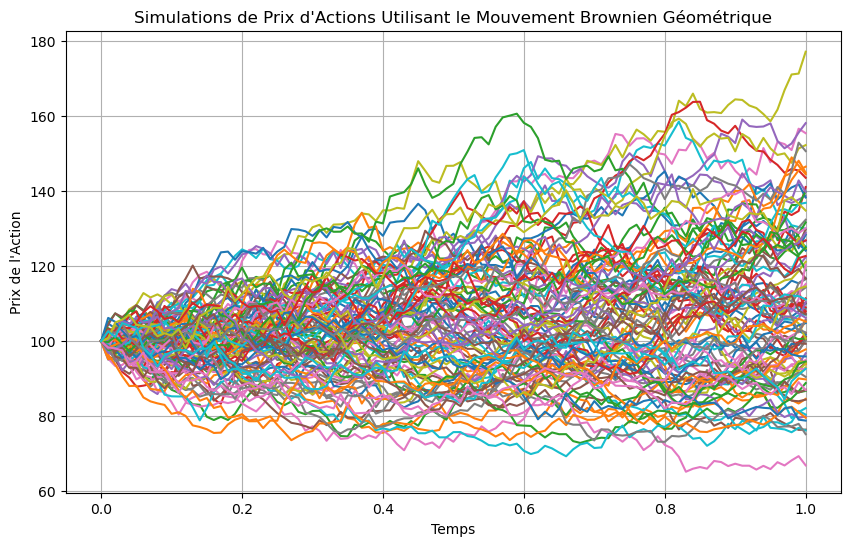

In [128]:
# Tracer les simulations
plt.figure(figsize=(10, 6))
for i in range(N):
    plt.plot(np.linspace(0, T, n + 1), prices[i])
plt.title('Simulations de Prix d\'Actions Utilisant le Mouvement Brownien Géométrique')
plt.xlabel('Temps')
plt.ylabel('Prix de l\'Action')
plt.grid(True)
plt.savefig('simulations_prix_actions.png')
plt.show()


### ITM Paths

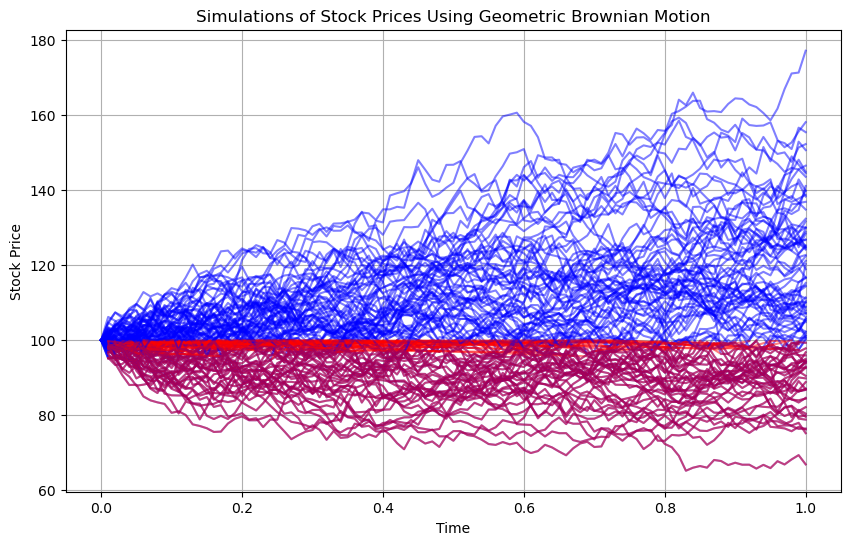

In [129]:
# Plotting the simulations and highlighting ITM points
plt.figure(figsize=(10, 6))
time_points = np.linspace(0, T, n + 1)

for i in range(N):
    plt.plot(time_points, prices[i], color='blue',alpha=0.5)  # plot all paths with lower alpha
    # Highlight ITM points
    itm_points = prices[i] < 100
    plt.plot(time_points[itm_points], prices[i][itm_points], color='red',alpha=0.5)  # highlight ITM points

plt.title('Simulations of Stock Prices Using Geometric Brownian Motion')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.grid(True)
plt.savefig('simulations_prix_actions_itm.png')
plt.show()

### Payoff of ITM Paths

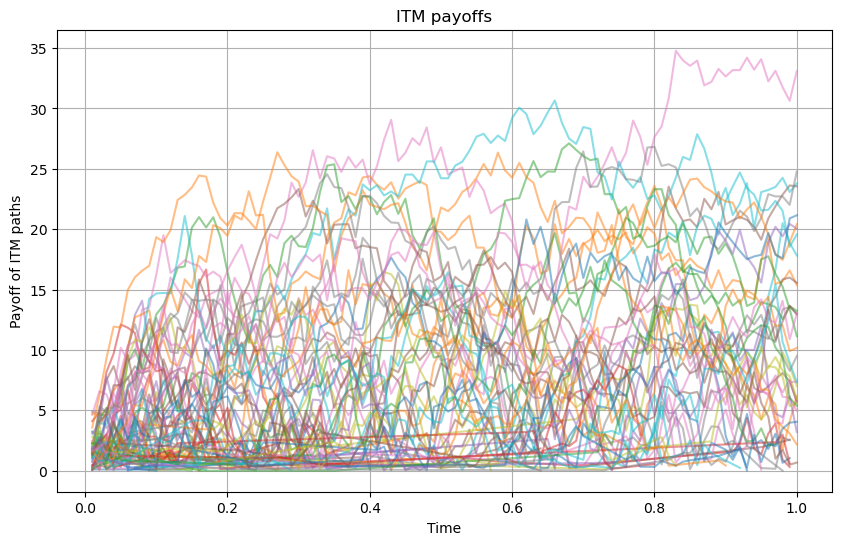

In [130]:
# Plotting the simulations and highlighting ITM points
plt.figure(figsize=(10, 6))
time_points = np.linspace(0, T, n + 1)

for i in range(N):

    itm_points = prices[i] < 100
    plt.plot(time_points[itm_points],100- prices[i][itm_points], alpha=0.5)  # highlight ITM points

plt.title('ITM payoffs')
plt.xlabel('Time')
plt.ylabel('Payoff of ITM paths')
plt.grid(True)
plt.savefig('simulations_prix_actions_itm.png')
plt.show()

## Longstaff-Schwarz Algorithm 

In [163]:
t=-2

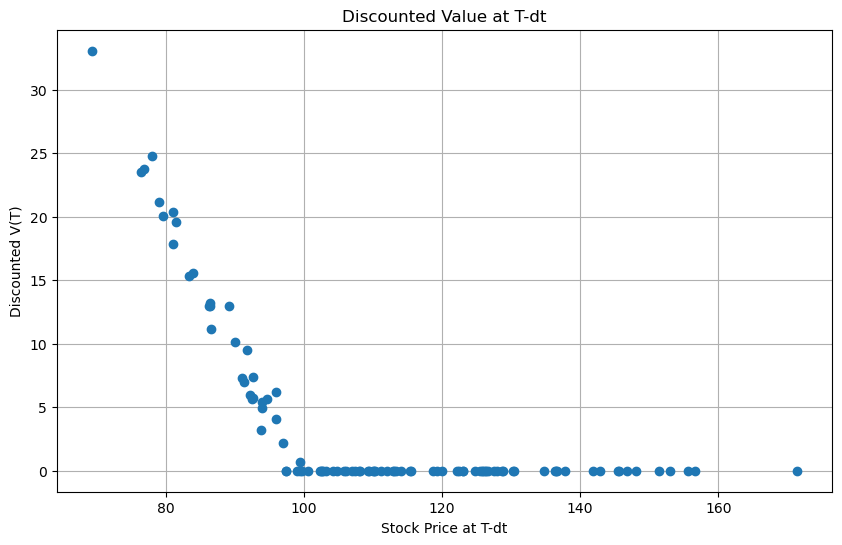

In [164]:
# Plotting the simulations and highlighting ITM points
plt.figure(figsize=(10, 6))
time_points = np.linspace(0, T, n + 1)


payoff = np.maximum(100 - prices[:, t + 1], 0)
itm_points =  prices[:, -2] < 100
plt.plot(prices[:, t],np.exp(-r*T/n)*(payoff ),"o")  # highlight ITM points

plt.title('Discounted Value at T-dt')
plt.xlabel('Stock Price at T-dt')
plt.ylabel('Discounted V(T)')
plt.grid(True)
plt.savefig('simulations_prix_actions_itm.png')
plt.show()

In [13]:
def laguerre(x, i):
    # Example definitions, assuming a reasonable implementation of Laguerre polynomials
    if i == 0:
        return np.ones(len(x))
    if i == 1:
        return np.exp(-x / 2)
    elif i == 2:
        return np.exp(-x / 2) * (1 - x)
    elif i == 3:
        return np.exp(-x / 2) * (1 - 2 * x + x**2)
    else:
        return np.zeros_like(x)




In [ ]:

in_the_money =  prices[:, t] < 100
reg_X = np.vstack([
                laguerre(prices[in_the_money, t]/S0,i) for i in range(4)
            ]).T
            # Actualisation des valeurs futures
payoff = np.maximum(100 - prices[in_the_money, t + 1], 0)
reg_y = np.exp(-r*T/n)*(payoff )

In [166]:
fitted_coeffs = np.linalg.lstsq(reg_X, reg_y, rcond= None)[0]
continuation_values = np.dot(reg_X, fitted_coeffs)

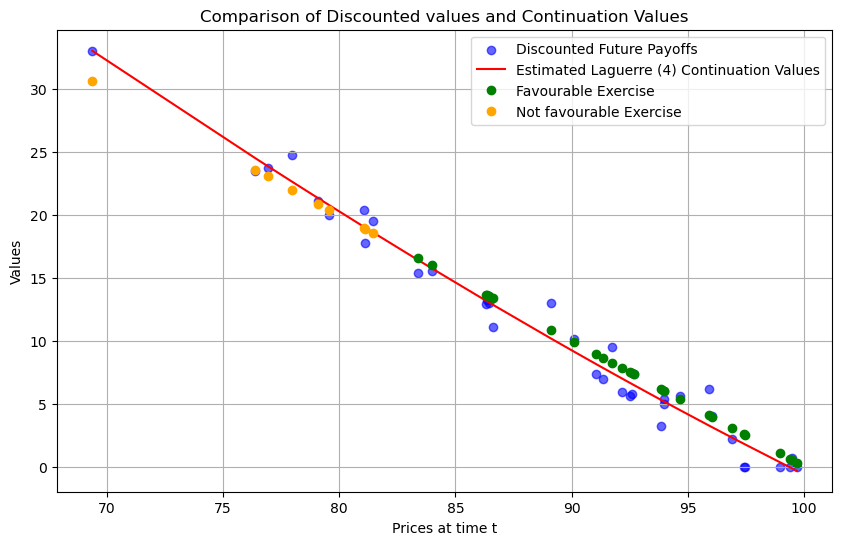

In [167]:
# Determine exercise decision
exercise = np.maximum(100 - prices[in_the_money, t], 0) > continuation_values
exercise_payoff = np.maximum(100 - prices[in_the_money][exercise, t], 0)
exercise_payoff2= np.maximum(100 - prices[in_the_money][~exercise, t], 0)
y=sorted(continuation_values, reverse=True)
x=sorted(prices[in_the_money, t])

# Plotting prices[in_the_money, t] on the X-axis and both continuation_values and reg_y on the Y-axis
plt.figure(figsize=(10, 6))
plt.scatter(prices[in_the_money, t], reg_y, color='blue', label='Discounted Future Payoffs', alpha=0.6)
plt.plot(x,y, color='red', label='Estimated Laguerre (4) Continuation Values')
plt.plot(prices[in_the_money][exercise, t], exercise_payoff, "o", color='green', label='Favourable Exercise')
plt.plot(prices[in_the_money][~exercise, t], exercise_payoff2, "o", color='orange', label='Not favourable Exercise ')

plt.title('Comparison of Discounted values and Continuation Values')
plt.xlabel('Prices at time t')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.savefig('prices_vs_reg_y_continuation_values.png')
plt.show()

In [168]:
# Strike price
K = 100

In [169]:

def longstaff_schwartz_put_option_demo(S0, paths, K, r, sigma, T, dt):
    num_paths, num_time_steps = paths.shape
    payoffs = np.maximum(K - paths, 0)
    values = np.copy(payoffs)
    time = T
    
    # To store continuation values and exercise decisions
    continuation_values_list = []
    exercise_decisions = np.zeros_like(values, dtype=bool)
    
    for t in range(num_time_steps - 2, -1, -1):
        time -= dt
        in_the_money = paths[:, t] < K
        if np.any(in_the_money):
            reg_X = np.vstack([
                laguerre(paths[in_the_money, t] / S0, i) for i in range(4)
            ]).T
            reg_y = values[in_the_money, t + 1] * np.exp(-r * dt)
            fitted_coeffs = np.linalg.lstsq(reg_X, reg_y, rcond=None)[0]
            continuation_values = np.dot(reg_X, fitted_coeffs)
            
            continuation_values_full = np.zeros(num_paths)
            continuation_values_full[in_the_money] = continuation_values
            continuation_values_list.append(continuation_values_full)
            
            exercise = payoffs[in_the_money, t] > continuation_values
            exercise_decisions[in_the_money, t] = exercise
            values[in_the_money, t] = np.where(exercise, payoffs[in_the_money, t], values[in_the_money, t + 1] * np.exp(-r * dt))
        
        values[~in_the_money, t] = values[~in_the_money, t + 1] * np.exp(-r * dt)
    
    option_price = np.mean(values[:, 0]) * np.exp(-r * dt)
    option_prices = values[:, 0] * np.exp(-r * dt)
    standard_error = np.std(option_prices) / np.sqrt(num_paths)
    confidence_interval = (option_price - 1.96 * standard_error, option_price + 1.96 * standard_error)
    
    return option_price, confidence_interval, continuation_values_list, exercise_decisions


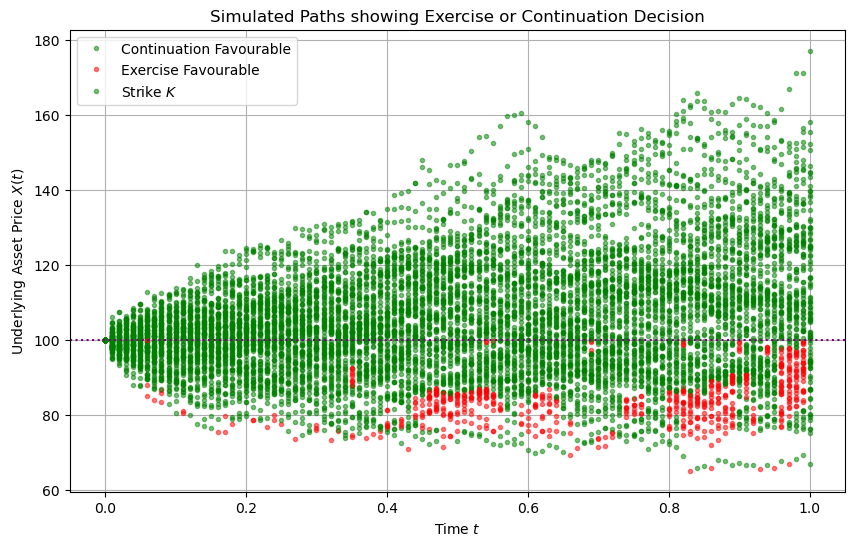

In [170]:
# Calculate option price and get continuation values and exercise decisions
option_price, confidence_interval, continuation_values_list, exercise_decisions = longstaff_schwartz_put_option_demo(S0, prices, K, r, sigma, T, T/50)

# Plotting the simulation paths and decisions
plt.figure(figsize=(10, 6))
time_points = np.linspace(0, T, n + 1)

for i in range(N):
    continuation_points = ~exercise_decisions[i]
    exercise_points = exercise_decisions[i]
    plt.plot(time_points[continuation_points], prices[i][continuation_points], 'g.', alpha=0.5)
    plt.plot(time_points[exercise_points], prices[i][exercise_points], 'r.', alpha=0.5)

# Add strike price line
plt.axhline(y=K, color='purple', linestyle=':', label='Strike K')

# Add titles and labels
plt.title('Simulated Paths showing Exercise or Continuation Decision')
plt.xlabel('Time $t$')
plt.ylabel('Underlying Asset Price $X(t)$')
plt.legend(['Continuation Favourable', 'Exercise Favourable', 'Strike $K$'])

# Show plot
plt.grid(True)
plt.show()

### Choose t from 0 to N-1

In [171]:
t=3

In [172]:
in_the_money =  prices[:, t] < 100
reg_X = np.vstack([
                laguerre(prices[in_the_money, t]/S0,i) for i in range(4)
            ]).T
            # Actualisation des valeurs futures
payoff = np.maximum(100 - prices[in_the_money, t + 1], 0)
reg_y = np.exp(-r*T/n)*(payoff )
fitted_coeffs = np.linalg.lstsq(reg_X, reg_y, rcond= None)[0]
continuation_values = np.dot(reg_X, fitted_coeffs)

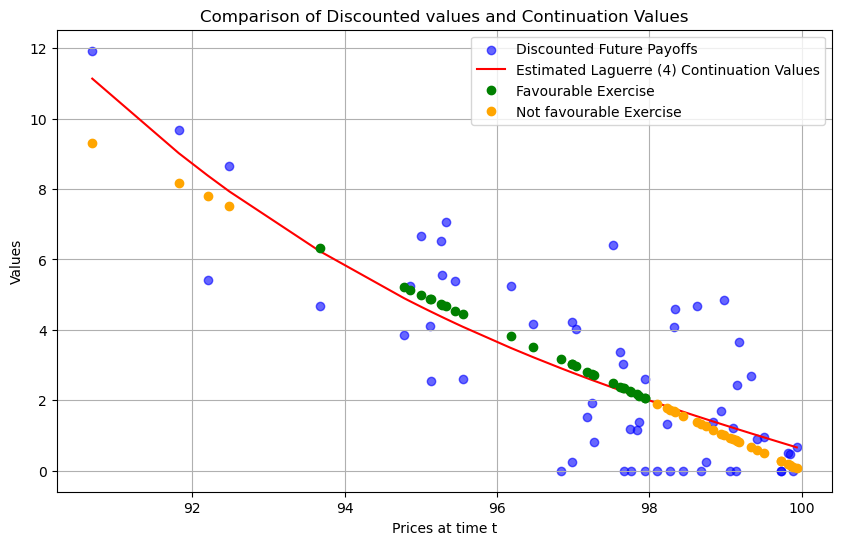

In [173]:
# Determine exercise decision
exercise = np.maximum(100 - prices[in_the_money, t], 0) > continuation_values
exercise_payoff = np.maximum(100 - prices[in_the_money][exercise, t], 0)
exercise_payoff2= np.maximum(100 - prices[in_the_money][~exercise, t], 0)
y=sorted(continuation_values, reverse=True)
x=sorted(prices[in_the_money, t])

# Plotting prices[in_the_money, t] on the X-axis and both continuation_values and reg_y on the Y-axis
plt.figure(figsize=(10, 6))
plt.scatter(prices[in_the_money, t], reg_y, color='blue', label='Discounted Future Payoffs', alpha=0.6)
plt.plot(x,y, color='red', label='Estimated Laguerre (4) Continuation Values')
plt.plot(prices[in_the_money][exercise, t], exercise_payoff, "o", color='green', label='Favourable Exercise')
plt.plot(prices[in_the_money][~exercise, t], exercise_payoff2, "o", color='orange', label='Not favourable Exercise ')

plt.title('Comparison of Discounted values and Continuation Values')
plt.xlabel('Prices at time t')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.savefig('prices_vs_reg_y_continuation_values.png')
plt.show()

# APPLICATION: American Put Option 

In [175]:
# List of stock prices (S)
S = [36, 36, 36, 36, 38, 38, 38, 38, 40, 40, 40, 40, 42, 42, 42, 42, 44, 44, 44, 44]

# List of volatilities (σ)
sigmas = [0.20, 0.20, 0.40, 0.40, 0.20, 0.20, 0.40, 0.40, 0.20, 0.20, 0.40, 0.40, 0.20, 0.20, 0.40, 0.40, 0.20, 0.20, 0.40, 0.40]

# List of times to maturity (T)
T2 = [1.0, 2.0, 1.0, 2.0, 1.0, 2.0, 1.0, 2.0, 1.0, 2.0, 1.0, 2.0, 1.0, 2.0, 1.0, 2.0, 1.0, 2.0, 1.0, 2.0]


In [9]:
def longstaff_schwartz_put_option(S0,paths, K, r, sigma, T, dt):
    num_paths, num_time_steps = paths.shape
    payoffs = np.maximum(K - paths, 0)
    values = np.copy(payoffs)  # Les valeurs futures actualisées des options à chaque chemin et à chaque pas de temps
    time = T
    for t in range(num_time_steps - 2, -1, -1):  # On commence à l'avant-dernier pas de temps
        time -= dt
        in_the_money = paths[:, t] < K
        if np.any(in_the_money):
            # Préparation des caractéristiques pour la régression
            reg_X = np.vstack([
                laguerre(paths[in_the_money, t]/S0,i) for i in range(4)
            ]).T
            # Actualisation des valeurs futures
            reg_y = values[in_the_money, t + 1] * np.exp(-r * dt)
            fitted_coeffs = np.linalg.lstsq(reg_X, reg_y, rcond= None)[0]
            continuation_values = np.dot(reg_X, fitted_coeffs)

            # Decision d'exercice anticipé
            exercise = payoffs[in_the_money, t] > continuation_values
            values[in_the_money, t] = np.where(exercise, payoffs[in_the_money, t], values[in_the_money, t + 1] * np.exp(-r * dt))
       
        # Actualisation des valeurs pour les chemins non "in the money"
        values[~in_the_money, t] = values[~in_the_money, t + 1] * np.exp(-r * dt)
   
    # Estimation du prix de l'option en prenant la moyenne des valeurs actualisées au temps 0
    option_price = np.mean(values[:, 0])* np.exp(-r * dt)
    #Calculate the confidence interval
    option_prices = values[:, 0] * np.exp(-r * dt)
    standard_error = np.std(option_prices) / np.sqrt(num_paths)
    confidence_interval = (option_price - 1.96 * standard_error, option_price + 1.96 * standard_error)
    
    return option_price, confidence_interval


In [225]:
N=100000

In [251]:
def simulate_stock_price(S0, r, sigma, T, n, N, seed=None):
    if seed is not None:
        np.random.seed(seed)
    dt = T / n
    N_half = N // 2
    gaussians = np.random.normal(0, 1, (N_half, n))
    gaussians_antithetic = -gaussians
    gaussians_full = np.vstack([gaussians, gaussians_antithetic])
    increments = (r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * gaussians_full
    log_prices = np.cumsum(increments, axis=1)
    prices = S0 * np.exp(log_prices)
    prices = np.hstack([np.full((N, 1), S0), prices])
    return prices

In [252]:
prices_=[]
CF=[]

for i in range (len(S)):
    S0_=S[i]
    sigma_=sigmas[i]
    K_=40
    T_=T2[i]
    n_ = int(T_*50)
    dt_ = T_ / n_
    r=0.06
    paths_ = simulate_stock_price(S0_,r,sigma_,T_, n_, N)
    p,cf= longstaff_schwartz_put_option(S0_,paths_, K_, r, sigma_,T_, dt_)
    prices_.append(p)
    CF.append(cf)
    paths_=[]

In [253]:
for i in range(len(prices_)):
    print("le prix de l'option i ",prices_[i],"l'intervalle de confiance est :",CF[i])

le prix de l'option i  4.465789645229859 l'intervalle de confiance est : (4.439989666368566, 4.4915896240911515)
le prix de l'option i  4.831883005618366 l'intervalle de confiance est : (4.801315842990751, 4.862450168245981)
le prix de l'option i  7.106880597508951 l'intervalle de confiance est : (7.054157377341452, 7.15960381767645)
le prix de l'option i  8.490249340541657 l'intervalle de confiance est : (8.428639671877715, 8.5518590092056)
le prix de l'option i  3.245073219927758 l'intervalle de confiance est : (3.2193588434616704, 3.2707875963938453)
le prix de l'option i  3.7427027179272323 l'intervalle de confiance est : (3.7117971517426325, 3.773608284111832)
le prix de l'option i  6.135235331090393 l'intervalle de confiance est : (6.083356837595249, 6.187113824585537)
le prix de l'option i  7.657891498405389 l'intervalle de confiance est : (7.596904046154683, 7.718878950656095)
le prix de l'option i  2.3087302478513765 l'intervalle de confiance est : (2.2845401759942763, 2.33292

In [254]:
LS_prices=[4.472,
 4.821,
 7.091,
 8.488,
 3.244,
 3.735,
 6.139,
 7.669,
 2.313,
 2.879,
 5.308,
 6.921,
 1.617,
 2.206,
 4.588,
 6.243,
 1.118,
 1.675,
 3.957,
 5.622]

In [255]:
finite_difference_american = [
    4.478, 4.840, 7.101, 8.508,
    3.250, 3.745, 6.148, 7.670,
    2.314, 2.885, 5.312, 6.920,
    1.617, 2.212, 4.582, 6.248,
    1.110, 1.690, 3.948, 5.647
]


In [ ]:
s=[np.abs(t-v) for t,v in zip(prices_,finite_difference_american )]

In [260]:
s

[0.006210354770141535,
 0.01088300561836597,
 0.015880597508950878,
 0.0022493405416579293,
 0.0010732199277576626,
 0.0077027179272324275,
 0.0037646689096071384,
 0.01110850159461041,
 0.0042697521486236845,
 0.00576957447495019,
 0.007957059043269155,
 0.03219674931392458,
 0.016576455964699477,
 0.0038720649098364923,
 0.020307430012429073,
 0.0022877612330596264,
 0.003946272333968492,
 0.01877647655436543,
 0.015889826836610776,
 0.028811581222679017]

### Jump Diffusions

In [4]:

def simulate_jump_component(lambda_, theta, n, num_trajectories, seed=None):
    if seed is not None:
        np.random.seed(seed)
    
    dt = 1 / n
    S_k = np.zeros((num_trajectories, n + 1))
    X_k_tilde = np.zeros((num_trajectories, n + 1))
    
    for k in range(1, n + 1):
        # Simulate Poisson jumps
        jumps = np.random.poisson(lambda_ * dt, num_trajectories)
        
        # Simulate normal increments and adjust for jumps
        Z_k = np.random.normal(0, theta, num_trajectories) * jumps
        S_k[:, k] = S_k[:, k - 1] + Z_k
        
        # Adjust S_k to get X_k_tilde
        X_k_tilde[:, k] = S_k[:, k] 

    return X_k_tilde

def simulate_gbm_component(S0, mu, sigma, T, n, num_trajectories, seed=None):
    if seed is not None:
        np.random.seed(seed)
    
    dt = T / n
    stock_prices = np.zeros((num_trajectories, n + 1))
    stock_prices[:, 0] = S0
    
    for i in range(1, n + 1):
        Z = np.random.normal(0, 1, num_trajectories)
        stock_prices[:, i] = stock_prices[:, i-1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
    
    return stock_prices

def simulate_combined_process(S0, mu, sigma, T, n, num_trajectories, lambda_, theta, seed=None):
    X_tilde = simulate_jump_component(lambda_, theta, n, num_trajectories, seed)
    X_gbm = simulate_gbm_component(S0, mu, sigma, T, n, num_trajectories, seed)
    
    # Combine X_tilde and X_gbm
    combined_process = X_gbm + X_tilde
    return combined_process


In [94]:
# Parameters
K=100
S0 = 90
mu = 0.06
sigma = 0.20
T = 1.0
n = 26
num_trajectories = 1000000  # Simulate one trajectory as per the second part of the exercise
lambda_ = 0.05
theta = 0.20

N=num_trajectories
prices= simulate_combined_process(S0, mu, sigma, T, n, num_trajectories, lambda_, theta, seed)


In [95]:
dt=T/n

In [96]:

# Calculate option price and get continuation values and exercise decisions
option_price, confidence_interval = longstaff_schwartz_put_option(S0, prices, K, mu, sigma, T, dt)

print(f"Prix de l'option américaine par le modèle LSM avec saut: {option_price}")
print(f"Intervalle de confiance à 95%: {confidence_interval}")


Prix de l'option américaine par le modèle LSM avec saut: 11.139046085299542
Intervalle de confiance à 95%: (11.124630597721083, 11.153461572878001)


In [97]:
# Parameters
K=100
S0 = 90
mu = 0.06
sigma = 0.20
T = 1.0
n = 26
num_trajectories = 100000  # Simulate one trajectory as per the second part of the exercise
lambda_ = 0.0
theta = 0.30

N=num_trajectories
prices= simulate_combined_process(S0, mu, sigma, T, n, num_trajectories, lambda_, theta, seed)


In [98]:

# Calculate option price and get continuation values and exercise decisions
option_price, confidence_interval = longstaff_schwartz_put_option(S0, prices, K, mu, sigma, T, dt)

print(f"Prix de l'option américaine par le modèle LSM sans saut: {option_price}")
print(f"Intervalle de confiance à 95%: {confidence_interval}")


Prix de l'option américaine par le modèle LSM sans saut: 11.17996441443981
Intervalle de confiance à 95%: (11.13404448438418, 11.22588434449544)


### on remarque que le prix sans saut est toujours superieur au prix avec saut car il y a moins de risque lorsqu'il n ya pas de saut 
